In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif, cross, dot

from desc.magnetic_fields import FourierCurrentPotentialField, ToroidalMagneticField, field_line_integrate

import time

import numpy as np
from numpy import ndarray

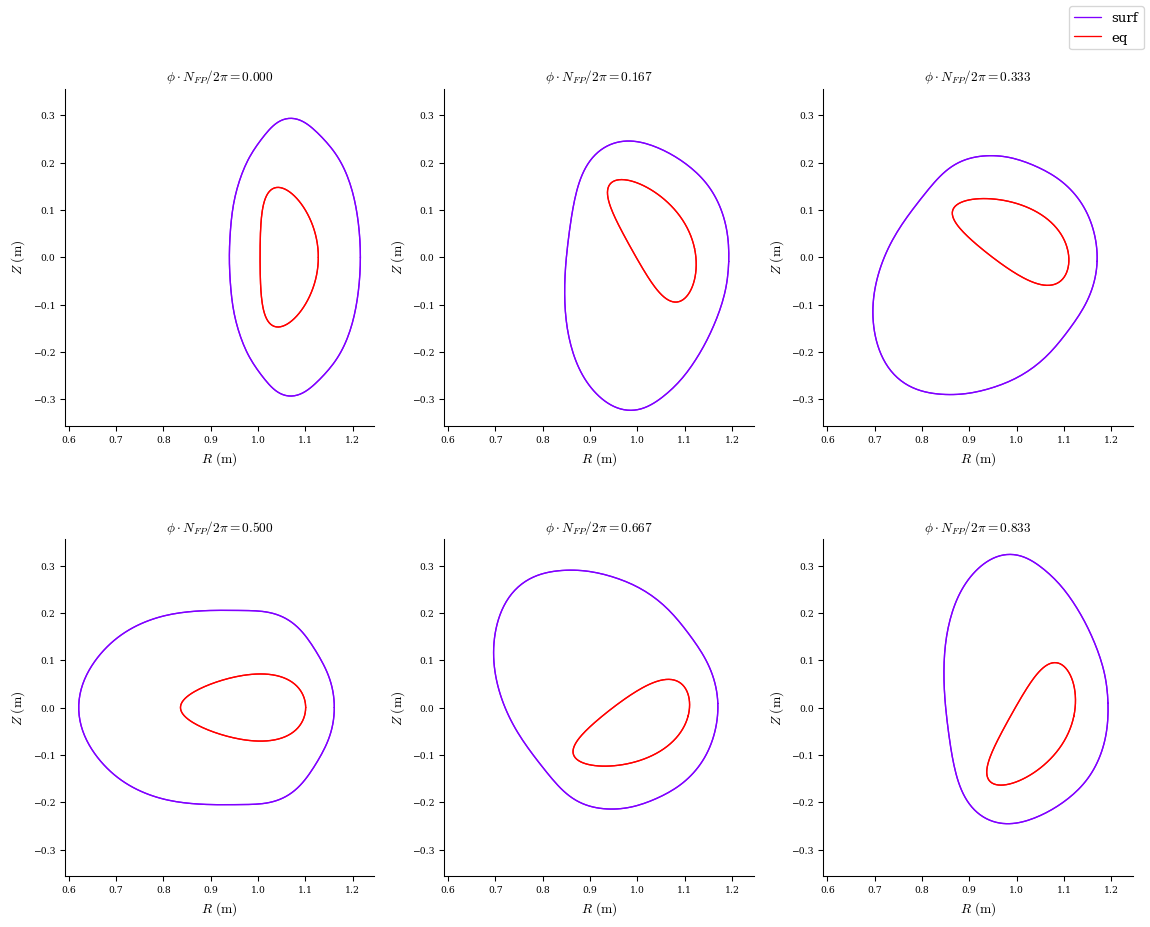

In [26]:
# Plasma surfaces
#"/scratch/gpfs/EKOLEMEN/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" 
eqname_QA = "input.QA_final_output.h5" #vacuum equilibrium
eq = desc.io.load(eqname_QA)[4]
# Winding surface
surf_winding = load("surf.h5")

# Plot both surfaces
plot_comparison([surf_winding,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0));

In [ ]:
# Evaluate Green's function for flat tori
sgrid = LinearGrid(
    M=220,
    N=220,
    NFP=surf_winding.NFP,
)

In [5]:
K = jnp.load('K_sour.npy') + jnp.load('K_sec.npy')

In [6]:
def _compute_flt_from_Current(K_at_grid, surface, coords, grid, basis="rpz"):
    """Compute magnetic field at a set of points.

    Parameters
    ----------
    K_at_grid : ndarray, shape (num_nodes,3)
        Surface current evaluated at points on a grid, which you want to calculate
        B from, should be in cartesian ("xyz") or cylindrical ("rpz") specifiec
        by "basis" argument
    surface : FourierRZToroidalSurface
        surface object upon which the surface current K_at_grid lies
    coords : array-like shape(N,3) or Grid
        cylindrical or cartesian coordinates to evlauate B at
    grid : Grid,
        source grid upon which to evaluate the surface current density K
    basis : {"rpz", "xyz"}
        basis for input coordinates and returned magnetic field

    Returns
    -------
    field : ndarray, shape(N,3)
        magnetic field at specified points

    """
    assert basis.lower() in ["rpz", "xyz"]
    if hasattr(coords, "nodes"):
        coords = coords.nodes
    coords = jnp.atleast_2d(coords)
    if basis == "rpz":
        coords = rpz2xyz(coords)
    else:
        K_at_grid = xyz2rpz_vec(K_at_grid, x=coords[:, 0], y=coords[:, 1])
    
    surface_grid = grid

    # compute and store grid quantities
    # needed for integration
    # TODO: does this have to be xyz, or can it be computed in rpz as well?
    data = surface.compute(["x", "|e_theta x e_zeta|"], grid=surface_grid, basis="xyz")

    _rs = xyz2rpz(data["x"])
    _K = K_at_grid

    # surface element, must divide by NFP to remove the NFP multiple on the
    # surface grid weights, as we account for that when doing the for loop
    # over NFP
    _dV = surface_grid.weights * data["|e_theta x e_zeta|"] / surface_grid.NFP

    def nfp_loop(j, f):
        # calculate (by rotating) rs, rs_t, rz_t
        phi = (surface_grid.nodes[:, 2] + j * 2 * jnp.pi / surface_grid.NFP) % (
            2 * jnp.pi
        )
        # new coords are just old R,Z at a new phi (bc of discrete NFP symmetry)
        rs = jnp.vstack((_rs[:, 0], phi, _rs[:, 2])).T
        rs = rpz2xyz(rs)
        K = rpz2xyz_vec(_K, phi=phi)
        fj = biot_savart_general(
            coords,
            rs,
            K,
            _dV,
        )
        f += fj
        return f

    B = fori_loop(0, surface_grid.NFP, nfp_loop, jnp.zeros_like(coords))
    
    if basis == "rpz":
        B = xyz2rpz_vec(B, x=coords[:, 0], y=coords[:, 1])
    return B

In [11]:
def get_B_function_for_field_line_trace(K_at_grid, surface, K_grid):
    def B_function(re, params=None, basis="rpz", source_grid=None, chunk_size=None):
        source_grid = K_grid if source_grid is None else source_grid
        return _compute_flt_from_Current(K_at_grid, surface, re, source_grid, basis="rpz")
    return B_function

In [ ]:
class CurrentPotentialField(ToroidalMagneticField):
    """Custom magnetic field defined by a surface current potential."""
    def compute_magnetic_field(
        self,
        coords,
        params=None,
        basis="rpz",
        source_grid=None,
        transforms=None,
        chunk_size=None,
    ):
        """Compute magnetic field at a set of points."""
        B_function = get_B_function_for_field_line_trace(K, surf_winding, sgrid)
        return B_function(
            coords,
            params=params,
            basis=basis,
            source_grid=source_grid,
            chunk_size=chunk_size,
        )

In [16]:
## to field line trace
Bfield_currpot = CurrentPotentialField(1, 1)

In [24]:
t0 = time.time()
ntransit = 1
nr = 9

start_grid = LinearGrid(rho=np.linspace(0.1, 1.0, nr), theta=0, zeta=0, NFP=eq.NFP)
data = eq.compute(["R", "Z"], grid=start_grid, basis="rpz")
r0 = data["R"]
z0 = data["Z"]
phis = np.linspace(0, ntransit*2*np.pi, int(ntransit*4 + 1))

# integrate field lines
field_R, field_Z = field_line_integrate(
    r0, z0, phis, Bfield_currpot, max_steps=1000, rtol=1e-6, atol=1e-6
)

t_elapse = time.time() - t0
print(
    f" field line tracing done, took {t_elapse:.2f} seconds which"
    f" is {t_elapse/60:.2f} mins or  {t_elapse/3600} hours"
)

 field line tracing done, took 3.31 seconds which is 0.06 mins or  0.0009180833233727349 hours


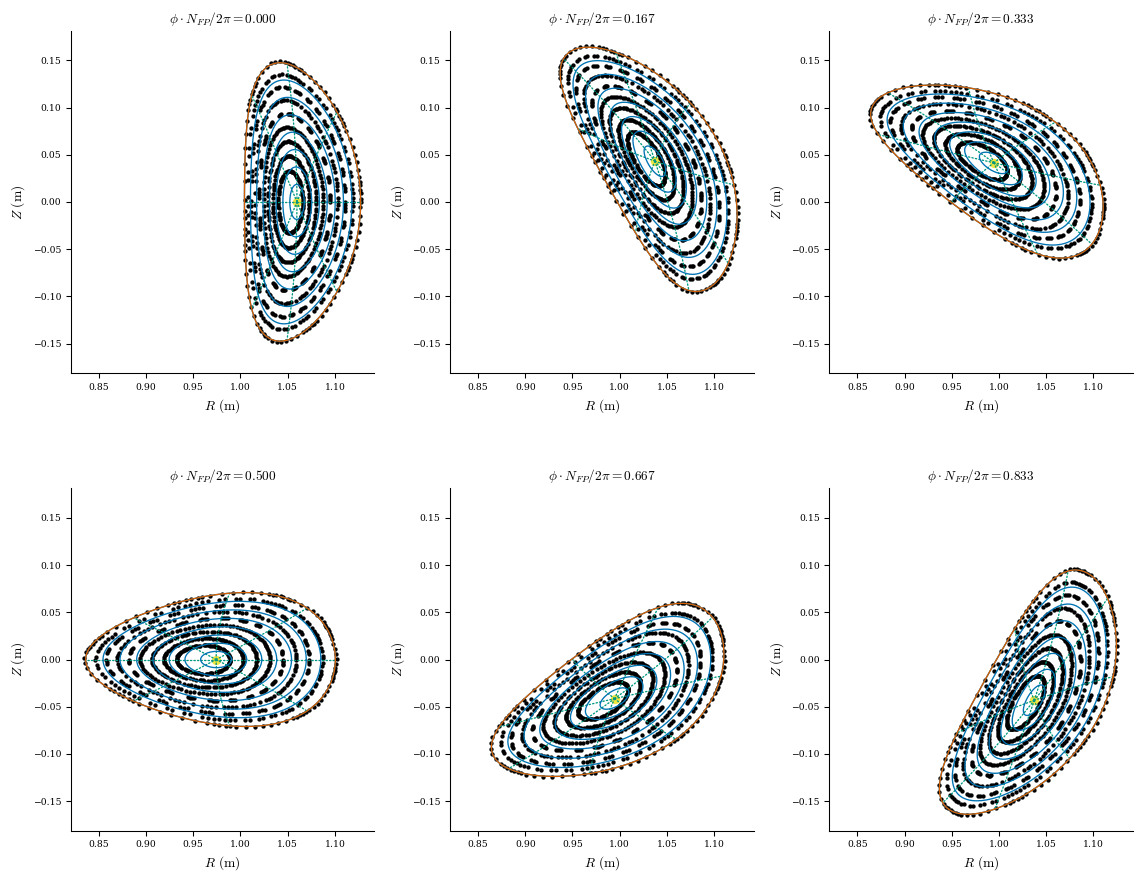

In [ ]:
# this can take couple minutes (took 2 mins on my laptop)
fig, ax = plot_surfaces(eq)
fig, ax = poincare_plot(
    Bfield_currpot, r0, z0, NFP=eq.NFP, ax=ax, color="k", ntransit=100
)